<a href="https://colab.research.google.com/github/NikkiShah93/Python/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'amazon-fine-food-reviews:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F18%2F2157%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240423%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240423T170331Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D62ba03f37d98e30862ee1660fdb41db1e17834db164aa8b35a77a23f9abf8af91183dc360ba5f212a127edc748d959114f48a74c5ef4bb707b9cacb4e6ffc44a65cdaf4708d31283b48050661b560757b9900eec4e1590a816bb854bdb195b3062b2cc94519d34cb30243c73f5a3f8ca57094648ed465d1eb9ee9f4b4dfdb47572ccf4ad4de60e137e287c001ad4537a6729765d5f4e71368c1fef7a777868be27b9ade23f534d239c6665966f778407273ffa72e05e8415abb344c1720a43659b9a5ec286c835a01dfa19d343bf6b2a2acbdefa92efc76b11db3684a6199e0c0798a8fd3b6144b51ad458212c4d8d41eda9b6eb6973c01f9bd6b8645619b4f4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 253873708 bytes downloaded
Downloaded and uncompressed: amazon-fine-food-reviews
Data source import complete.


## Sentiment Analysis

In this project, we will be using the Amazon Fine Food Reviews dataset and follow the steps below:
1. [Load and explore the data](#exploration)
2. Preprocess the data
3. [Start with the fist model - using NLTK](#nltkmodel)
4. [Develop a pipeline using Roberta Model](#roberta)
5. [Compare the results of the two model](#compare)

In [3]:
## first the imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
## the model related imports
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


<a id='exploration'>Load + Explore</a>

In [4]:
data_path = '/kaggle/input/amazon-fine-food-reviews/Reviews.csv'
data = pd.read_csv(data_path).iloc[:500,:] ## only getting the top 1k rows
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
## checking the types and see if there are nulls in any of the columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      500 non-null    int64 
 1   ProductId               500 non-null    object
 2   UserId                  500 non-null    object
 3   ProfileName             500 non-null    object
 4   HelpfulnessNumerator    500 non-null    int64 
 5   HelpfulnessDenominator  500 non-null    int64 
 6   Score                   500 non-null    int64 
 7   Time                    500 non-null    int64 
 8   Summary                 500 non-null    object
 9   Text                    500 non-null    object
dtypes: int64(5), object(5)
memory usage: 39.2+ KB


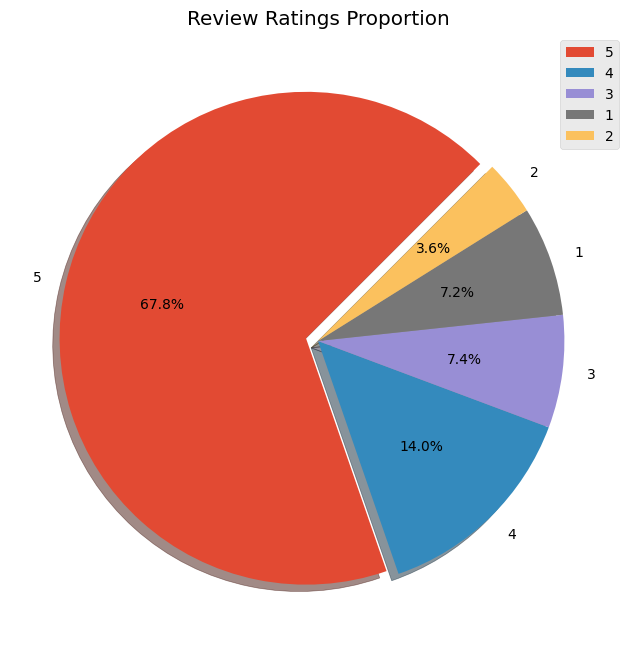

In [6]:
## checking the score distribution
plt.figure(figsize=(8, 8))
wedges, txt, _ = plt.pie(data.Score.value_counts(), labels=data.Score.value_counts().index,
       autopct='%.1f%%', explode=[0.05 if x == 5 else 0 for x in data.Score.value_counts().index],
        shadow=True, startangle=45
           )
plt.title('Review Ratings Proportion')
plt.legend(wedges, data.Score.value_counts().index, loc='upper right')

The majority of the ratings seem to be 5.

<a id = 'nltkmodel'>Staring with NLTK VADER Model</a>

In [7]:
## we will be using the sentiment analyizer from NLTK
sa = SentimentIntensityAnalyzer()
data['text_compound'] = pd.Series(data['Text'].apply(lambda x:sa.polarity_scores(x)['compound']))
data['summary_compound'] = pd.Series(data['Summary'].apply(lambda x:sa.polarity_scores(x)['compound']))
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,text_compound,summary_compound
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,0.9441,0.4404
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-0.5664,0.0000
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,0.8265,0.0000
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0.0000,0.0000
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,0.9468,0.6249


Text(0, 0.5, 'Summary Polarity Score')

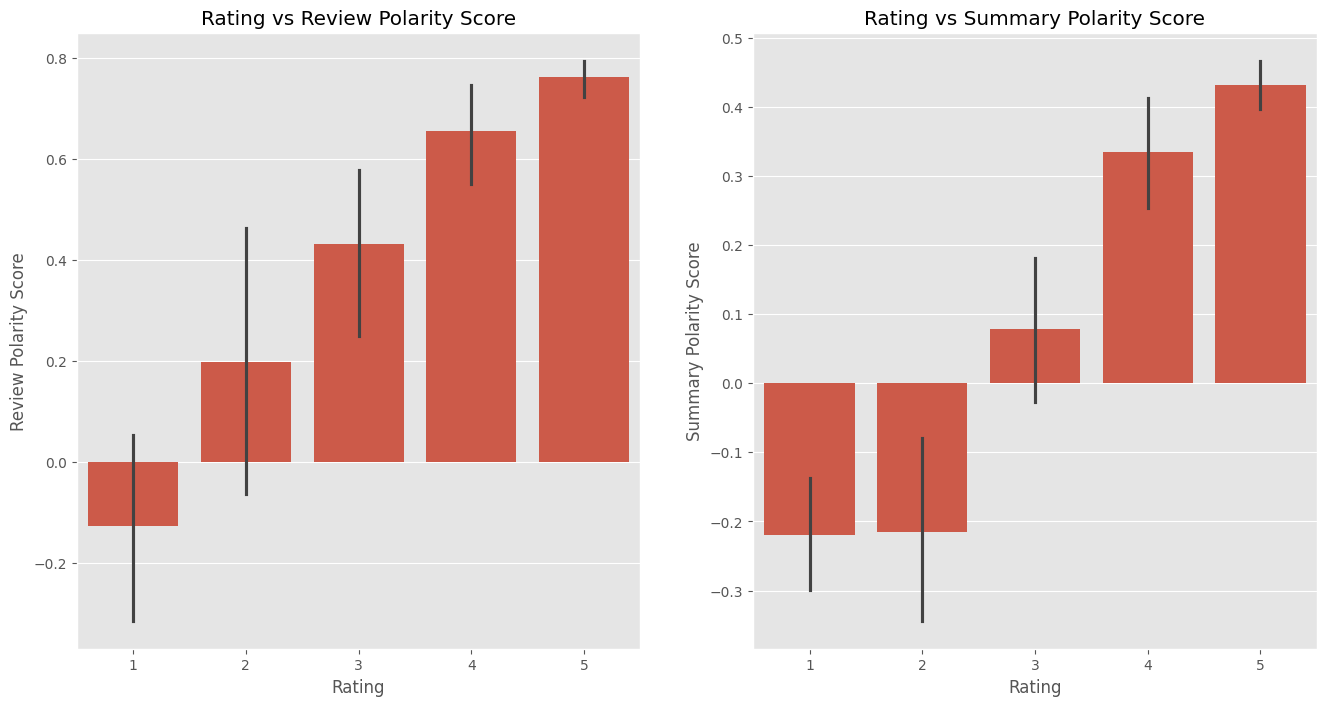

In [8]:
## plotting the result
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize=(16,8))
sns.barplot(x=data.Score, y = data.text_compound, ax=ax[0])
ax[0].set_title('Rating vs Review Polarity Score')
ax[0].set_xlabel('Rating')
ax[0].set_ylabel('Review Polarity Score')
sns.barplot(x=data.Score, y = data.summary_compound, ax=ax[1])
ax[1].set_title('Rating vs Summary Polarity Score')
ax[1].set_xlabel('Rating')
ax[1].set_ylabel('Summary Polarity Score')

<a id = 'roberta'>Starting with the Roberta Model from Huggingface</a>

In [9]:
## The Roberta pre-trained model
!transformers-cli cache clear
model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest"
pipe = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path, max_length=512, truncation=True)
# tokenizer = AutoTokenizer.from_pretrained(model_path)
# model = AutoModelForSequenceClassification.from_pretrained(model_path)

2024-04-23 18:15:59.966746: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 18:15:59.966805: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 18:15:59.967641: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-23 18:16:01.146599: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
usage: transformers-cli <command> [<args>]
Transformers CLI tool: error: argument {convert,download,env,run,serve,login,whoami,logout,repo,add-new-model,add-new-model-like,lfs-enable-largefiles,lfs-multipart-upload,pt-to-tf}: invalid choice:

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [10]:
# !transformers-cli cache clear
# model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest"
# pipe = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path, max_length=512, truncation=True)
# test = data.iloc[:10].copy()
data['text_roberta_score'] = data['Text'].apply(lambda x: pipe(x)[0]['score'])
data['summary_roberta_score'] = data['Summary'].apply(lambda x: pipe(x)[0]['score'])
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,text_compound,summary_compound,text_roberta_score,summary_roberta_score
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,0.9441,0.4404,0.950607,0.920776
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-0.5664,0.0000,0.716768,0.742778
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,0.8265,0.0000,0.916966,0.759618
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0.0000,0.0000,0.949957,0.737874
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,0.9468,0.6249,0.986190,0.959504


<a id='compare'>Comparing the Results</a>

<Figure size 1600x1000 with 0 Axes>

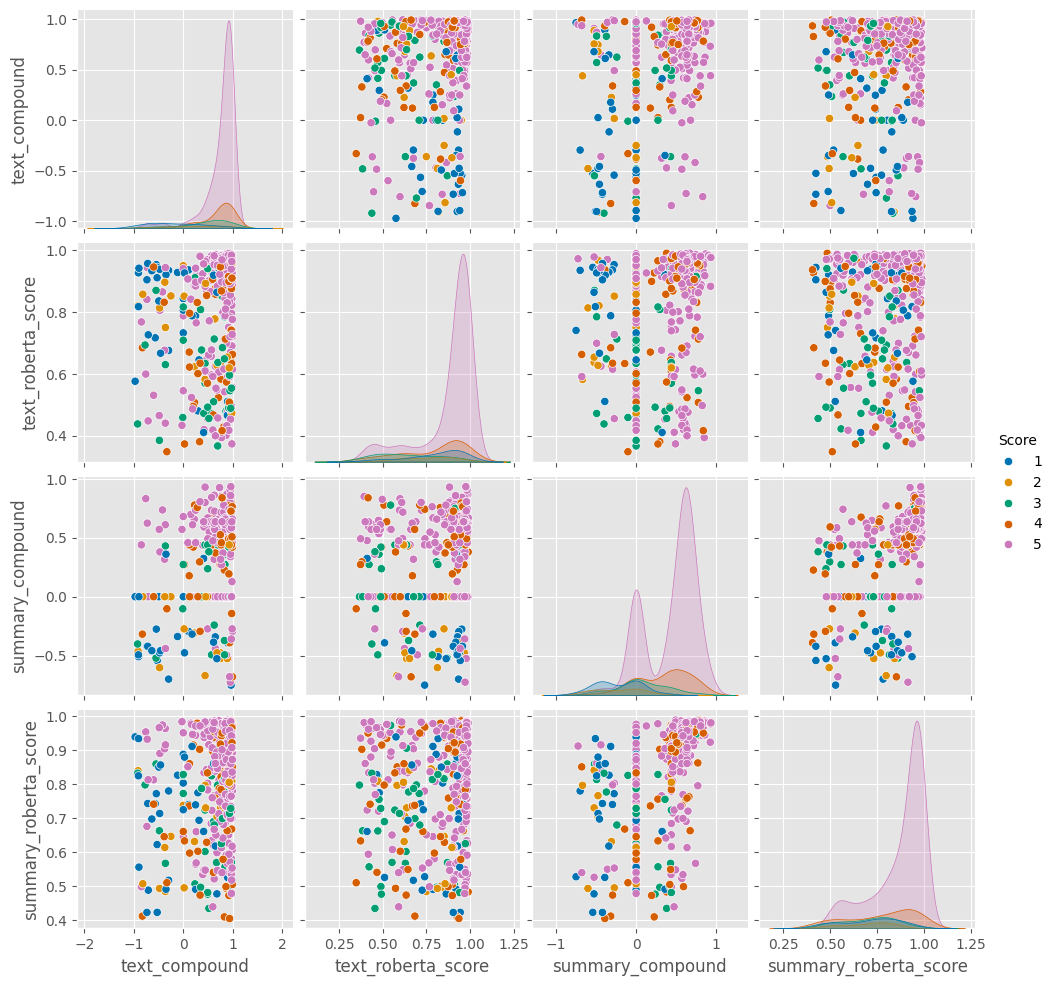

In [11]:
## comparing the results side-by-side
plt.figure(figsize=(16, 10))
sns.pairplot(data=data, vars = ['text_compound', 'text_roberta_score', 'summary_compound', 'summary_roberta_score'],
             hue='Score', palette='colorblind')